# Kolmogorov-Smirnov Test

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as     plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, roc_auc_score


## Functions

In [2]:
def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.
    
    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.
    
    Returns:
        cdf = CDF_{sample}(x)
    '''
    
    # Sorts the sample, if needed
    if sort:
        sample.sort()
    
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

## Classification evaluation with KS test

### Create synthetic dataset

In [3]:
from sklearn.model_selection import train_test_split

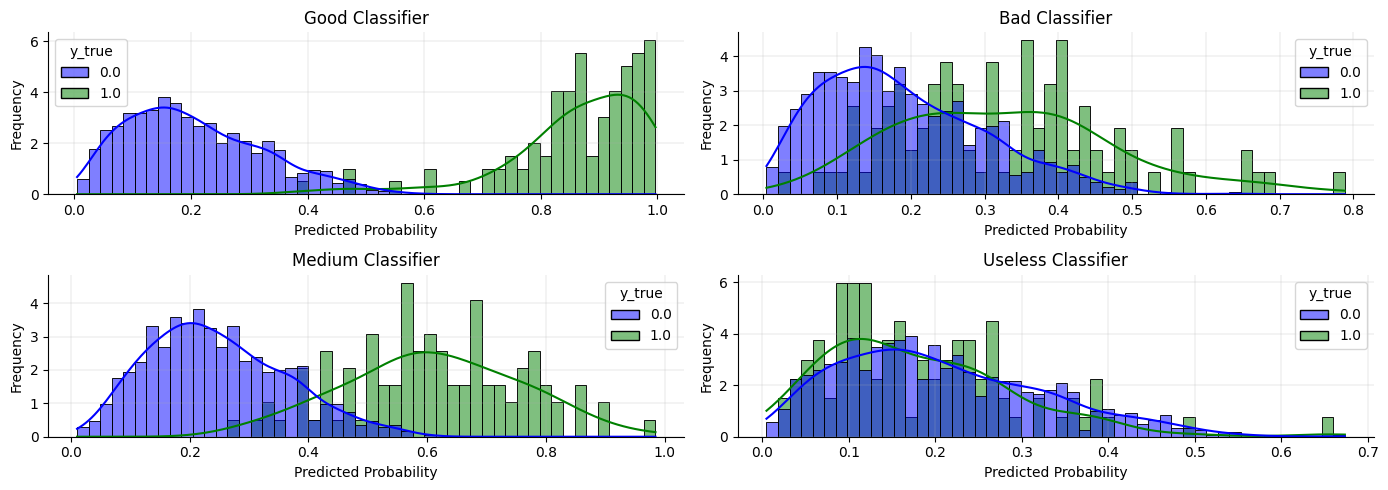

In [4]:
# simulate a true label from fraud detection problem inbalanced
np.random.seed(42)
n = 1000
n_fraud = 100

y = np.zeros(n)
y[:n_fraud] = 1


# simulate a got score prediction score in 0,1. simulating a classification close to 0 from n_fraud -1 and close to 1 from n_fraud to n

y_score_1 = np.random.beta(5, 1, n_fraud)
y_score_0 = np.random.beta(2, 8, n - n_fraud)
y_score = np.concatenate([y_score_1, y_score_0])
df_good_classifier= pd.DataFrame({'y_true': y, 'score': y_score})

def simulate_assimetric_classifier(size_sample: int, n_fraud: int, alpha0: int, beta0: int, alpha1: int, beta1: int):
    np.random.seed(42)
    y = np.zeros(size_sample)
    y[:n_fraud] = 1
    y_score_1 = np.random.beta(alpha1, beta1, n_fraud)
    y_score_0 = np.random.beta(alpha0, beta0, size_sample - n_fraud)
    y_score = np.concatenate([y_score_1, y_score_0])
    df = pd.DataFrame({'y_true': y, 'score': y_score})
    return df

df_good_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=8, alpha1=5, beta1=1)
df_bad_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=9, alpha1=3, beta1=6)
df_medium_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=3, beta0=9, alpha1=5, beta1=3)
df_useless_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=8, alpha1=2, beta1=8)
def plot_hist(df: pd.DataFrame, title: str, ax: plt.Axes, color0: str = 'b', color1: str = 'g'):
    sns.histplot(data=df, x='score', hue='y_true', kde=True, bins=50, ax=ax, common_norm=False, stat="density", palette={0: color0, 1: color1})
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # turn on y axis grid lines with a transparency and gray color
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
    
fig, ax = plt.subplots(2, 2, figsize=(14, 5))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_hist(df_good_classifier, 'Good Classifier', ax1)
plot_hist(df_bad_classifier, 'Bad Classifier', ax2)
plot_hist(df_medium_classifier, 'Medium Classifier', ax3)
plot_hist(df_useless_classifier, 'Useless Classifier', ax4)
plt.tight_layout()
plt.show()


## Evaluate KS for  each classifier

In this case we will use the KS to evaluate whether the distributions of the classes are identical or not

The higher the KS statistic, the better.

In [5]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

In [6]:
def evaluate_ks_and_roc_auc(df: pd.DataFrame, proba_col: str, true_value_col: str):
    
    # Recover each class
    class0 = df[df[true_value_col] == 0]
    class1 = df[df[true_value_col] == 1]
    
    ks = ks_2samp(class0[proba_col], class1[proba_col])
    roc_auc = roc_auc_score(df[true_value_col] , df[proba_col])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    return ks.statistic, roc_auc

In [7]:
print("Good classifier:")
ks_good, auc_good = evaluate_ks_and_roc_auc(df=df_good_classifier, proba_col='score', true_value_col='y_true')

Good classifier:
KS: 0.9689 (p-value: 4.246e-112)
ROC AUC: 0.9988


In [8]:
print("Medium classifier:")
ks_medium, auc_medium = evaluate_ks_and_roc_auc(df=df_medium_classifier, proba_col='score', true_value_col='y_true')

Medium classifier:
KS: 0.8233 (p-value: 2.863e-65)
ROC AUC: 0.9726


In [9]:
print("Bad classifier:")
ks_bad, auc_bad = evaluate_ks_and_roc_auc(df=df_bad_classifier, proba_col='score', true_value_col='y_true')

Bad classifier:
KS: 0.4189 (p-value: 9.736e-15)
ROC AUC: 0.7763


In [10]:
print("Useless classifier:")
ks_useless, auc_useless = evaluate_ks_and_roc_auc(df=df_useless_classifier, proba_col='score', true_value_col='y_true')

Useless classifier:
KS: 0.1411 (p-value: 5.121e-02)
ROC AUC: 0.4352


In [11]:

# Function to calculate cumulative distribution function for a sorted array
def get_classes_cdf_array(input_array: np.array):
    cumsum_ = np.cumsum(input_array)
    output = cumsum_ / cumsum_[-1]  # Normalize by the last value to ensure the CDF goes from 0 to 1
    
    return output

# Gets the class CDFs
def get_classes_cdf(df: pd.DataFrame, proba_col: str, true_value_col: str):

    # Mask for class 0
    mask0 = (df[true_value_col] == 0)
    
    # Recover each class, sorted by probability column
    class0 = df[mask0].sort_values(proba_col)[proba_col].values
    class1 = df[~mask0].sort_values(proba_col)[proba_col].values
    
    # Calculate the cumulative distribution functions
    cdf0 = get_classes_cdf_array(np.array(class0))
    cdf1 = get_classes_cdf_array(np.array(class1))
    
    # Results
    results = {
        'cdf0': cdf0,
        'cdf1': cdf1,
        'proba0': class0,
        'proba1': class1
    }
    
    return results


In [12]:
cdf_bad = get_classes_cdf(df=df_bad_classifier, proba_col='score', true_value_col='y_true')
cdf_medium = get_classes_cdf(df=df_medium_classifier, proba_col='score', true_value_col='y_true')
cdf_good = get_classes_cdf(df=df_good_classifier, proba_col='score', true_value_col='y_true')
cdf_useless = get_classes_cdf(df=df_useless_classifier, proba_col='score', true_value_col='y_true')

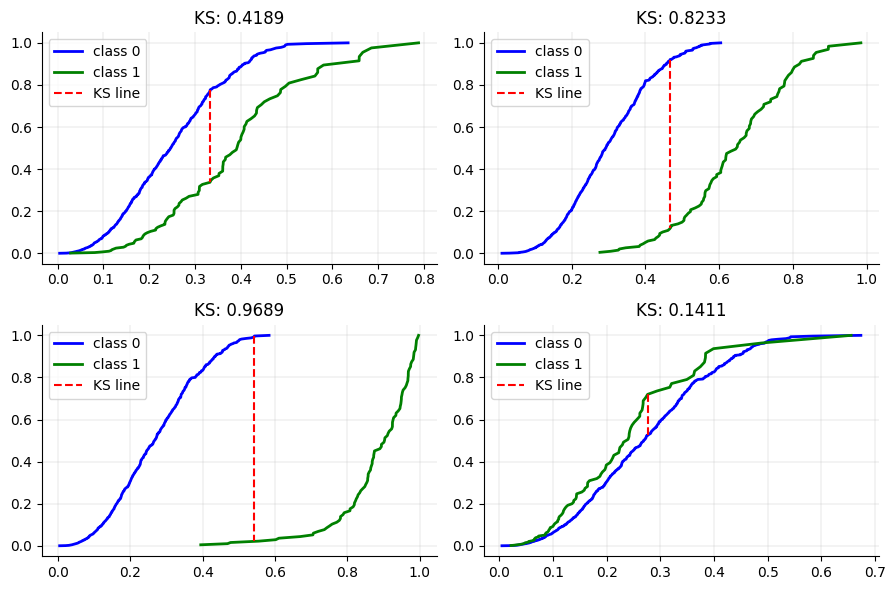

In [13]:


# Função para plotar as CDFs e a linha de KS
def plot_cdf_ks(cdf: dict, ks: float, ax: plt.Axes, color0='b', color1='g'):
    # Plotando as CDFs
    ax.plot(cdf['proba0'], cdf['cdf0'], color='b', linewidth=2)
    ax.plot(cdf['proba1'], cdf['cdf1'], color='g', linewidth=2)

    # Interpolando para garantir que tenham o mesmo número de pontos
    interp_cdf1 = interp1d(cdf['proba1'], cdf['cdf1'], kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Valores interpolados de 'cdf1' na grade de 'proba0'
    cdf1_interp = interp_cdf1(cdf['proba0'])
    
    # Encontrando o ponto de KS (onde a diferença é máxima)
    ks_x = cdf['proba0'][abs(cdf['cdf0'] - cdf1_interp).argmax()]
    ks_y0 = cdf['cdf0'][abs(cdf['cdf0'] - cdf1_interp).argmax()]
    ks_y1 = cdf1_interp[abs(cdf['cdf0'] - cdf1_interp).argmax()]

    # Desenhando a linha vertical no ponto de KS
    ax.vlines(x=ks_x, ymin=ks_y0, ymax=ks_y1, color='r', linestyle='--', label=f'KS = {ks:.4f}')
    
    # Configurando a legenda e o título
    ax.legend(["class 0", "class 1", f"KS line"])
    ax.set_title(f"KS: {ks:.4f}")
    
    # Ajustando a estética
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)


fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_cdf_ks(cdf_bad, ks_bad, ax1)
plot_cdf_ks(cdf_medium, ks_medium, ax2)
plot_cdf_ks(cdf_good, ks_good, ax3)
plot_cdf_ks(cdf_useless, ks_useless, ax4)
plt.tight_layout()
plt.show()


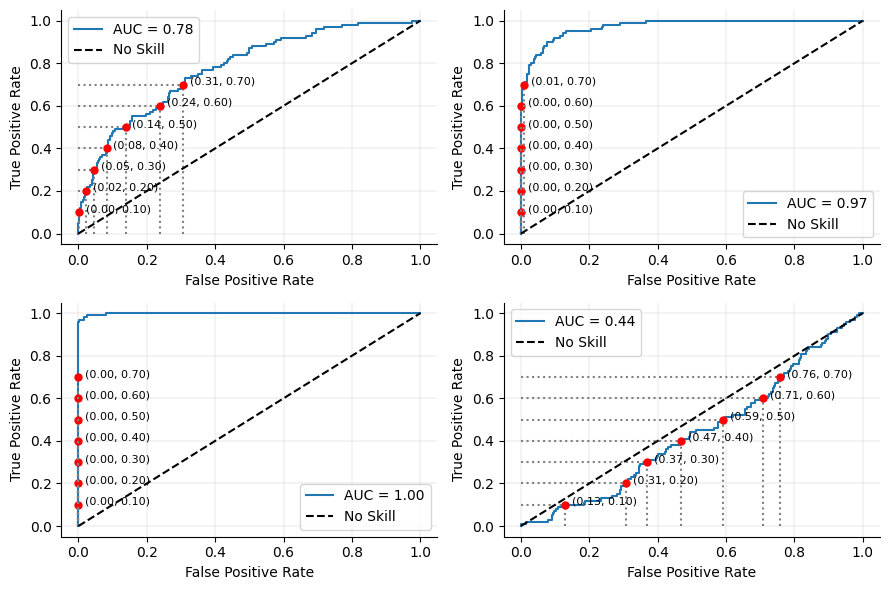

In [14]:
def plot_roc_curve(df: pd.DataFrame, proba_col: str, true_value_col: str, ax: plt.Axes):
    # Pegando as colunas de probabilidade e os valores verdadeiros
    y_true = df[true_value_col]
    y_pred_proba = df[proba_col]
    
    # Calculando a curva ROC e a AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    # Plotando a curva ROC
    ax.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    
    # Adicionar a marcação dos pontos 10%, 20%, 30%, ..., 70% de True Positive Rate
    marcacoes_tpr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

    # Para cada TPR, encontrar o ponto correspondente na curva
    for tpr_value in marcacoes_tpr:
        # Encontrar o índice do ponto mais próximo da TPR desejada
        closest_index = np.argmin(np.abs(tpr - tpr_value))
        fpr_value = fpr[closest_index]
        
        # Adicionar linhas pontilhadas
        ax.plot([fpr_value, fpr_value], [0, tpr_value], linestyle=':', color='gray')  # linha vertical
        ax.plot([0, fpr_value], [tpr_value, tpr_value], linestyle=':', color='gray')  # linha horizontal
        
        # Plotar o ponto com marcador tamanho 5
        ax.plot(fpr_value, tpr_value, 'ro', markersize=5)
        
        # Adicionar o texto com as coordenadas ao lado do ponto
        ax.text(fpr_value + 0.02, tpr_value, f'({fpr_value:.2f}, {tpr_value:.2f})', fontsize=8, color='black')
    
    # Adicionar a linha "No Skill" (classificador aleatório)
    ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill', color='black')
    
    # Configurar rótulos e a legenda
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    # Ajustando a estética
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
    
fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_roc_curve(df_bad_classifier, 'score', 'y_true', ax1)
plot_roc_curve(df_medium_classifier, 'score', 'y_true', ax2)
plot_roc_curve(df_good_classifier, 'score', 'y_true', ax3)
plot_roc_curve(df_useless_classifier, 'score', 'y_true', ax4)
plt.tight_layout()
plt.show()

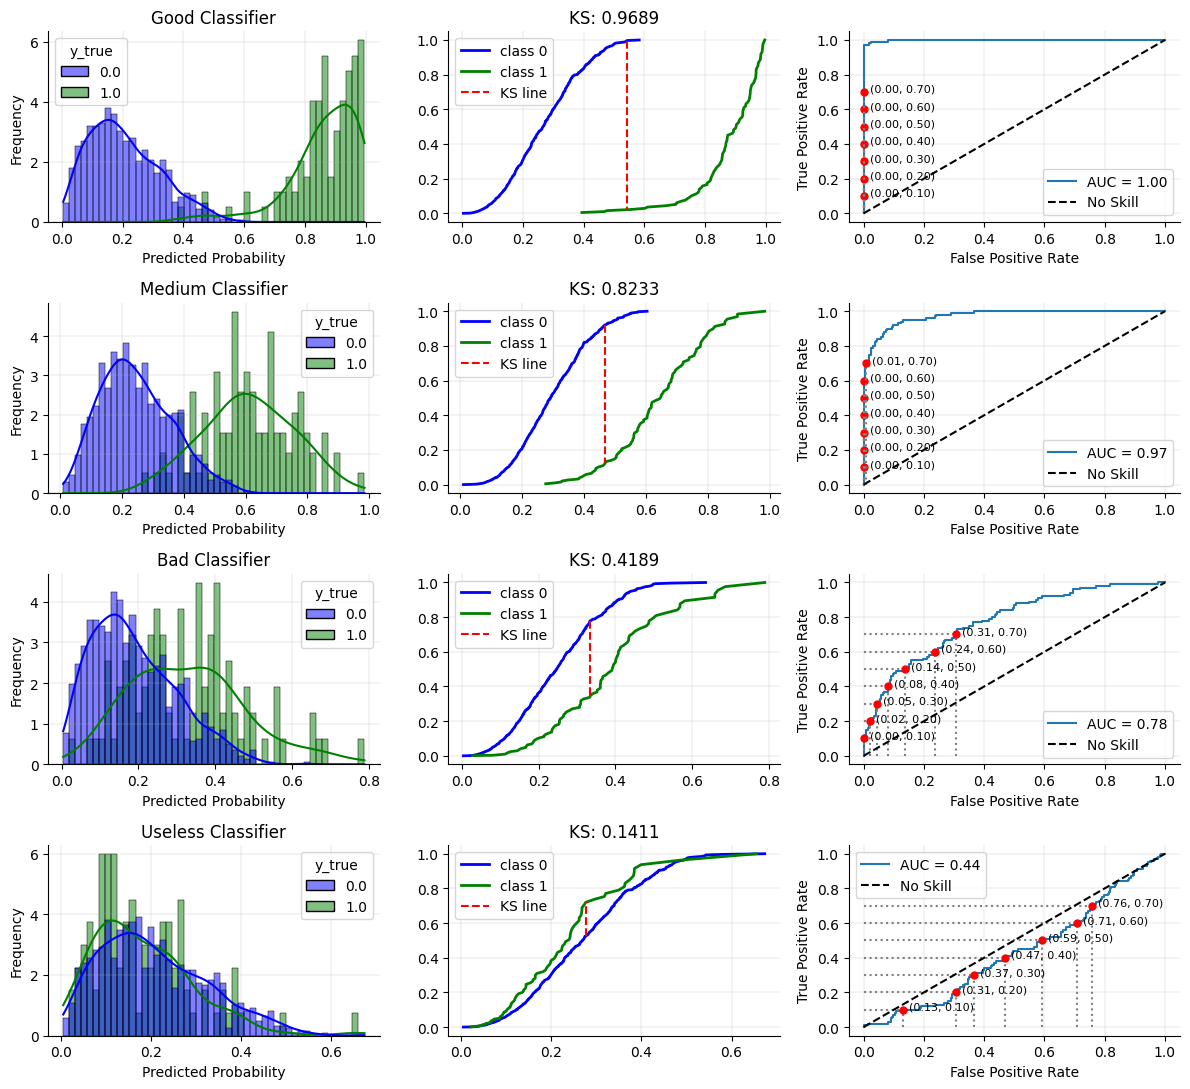

In [15]:
# plot cada distribuição de probabilidade a esquerda e sua cdf a direita com a linha de ks
fig, ax = plt.subplots(4, 3, figsize=(12, 11))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = ax.flatten()

# Good classifier
plot_hist(df_good_classifier, 'Good Classifier', ax1, color0='b', color1='g')
plot_cdf_ks(cdf_good, ks_good, ax2, color0='b', color1='g')
plot_roc_curve(df_good_classifier, 'score', 'y_true', ax3)

# Medium classifier
plot_hist(df_medium_classifier, 'Medium Classifier', ax4, color0='b', color1='g')
plot_cdf_ks(cdf_medium, ks_medium, ax5, color0='b', color1='g')
plot_roc_curve(df_medium_classifier, 'score', 'y_true', ax6)

# Bad classifier
plot_hist(df_bad_classifier, 'Bad Classifier', ax7, color0='b', color1='g')
plot_cdf_ks(cdf_bad, ks_bad, ax8, color0='b', color1='g')
plot_roc_curve(df_bad_classifier, 'score', 'y_true', ax9)

# Useless classifier
plot_hist(df_useless_classifier, 'Useless Classifier', ax10, color0='b', color1='g')
plot_cdf_ks(cdf_useless, ks_useless, ax11, color0='b', color1='g')
plot_roc_curve(df_useless_classifier, 'score', 'y_true', ax12)

plt.tight_layout()
plt.show()




In [28]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    savefig=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=14,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print always in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set tick labels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, ax, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    if savefig is not None:
        plt.savefig(savefig, format="png", dpi=300, transparent=True)
    return fig, ax1 


def configcell_text_and_colors(
    array_df, lin, col, oText, ax, fz, fmt, show_null_values
):
    """
    config cell text and colors
    and return text elements to add and to delete
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100

    # last line  and/or last column
    if (col == array_df.shape[0] - 1) or (lin == array_df.shape[0] - 1):
        # tots and percents
        if cell_val != 0:
            if (col == array_df.shape[0] - 1) and (lin == array_df.shape[0] - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == array_df.shape[0] - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == array_df.shape[0] - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % per_ok, "100%"][per_ok == 100]

        # text to delete
        text_del.append(oText)

        # text to add
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % cell_val, per_ok_s, "%.2f%%" % per_err]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i]
            )
            text_add.append(newText)

        # set black color for sum cells (last line and last column)
        if col == array_df.shape[0] - 1:
            ax.add_patch(plt.Rectangle((col, lin), 1, 1, fill=True, color="black"))
        if lin == array_df.shape[0] - 1:
            ax.add_patch(plt.Rectangle((col, lin), 1, 1, fill=True, color="black"))

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

    return text_add, text_del





/var/folders/0m/mtf6psc91_l02bjt_n2nd7bh0000gn/T/ipykernel_37697/2419695704.py:261: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % per_ok, "100%"][per_ok == 100]


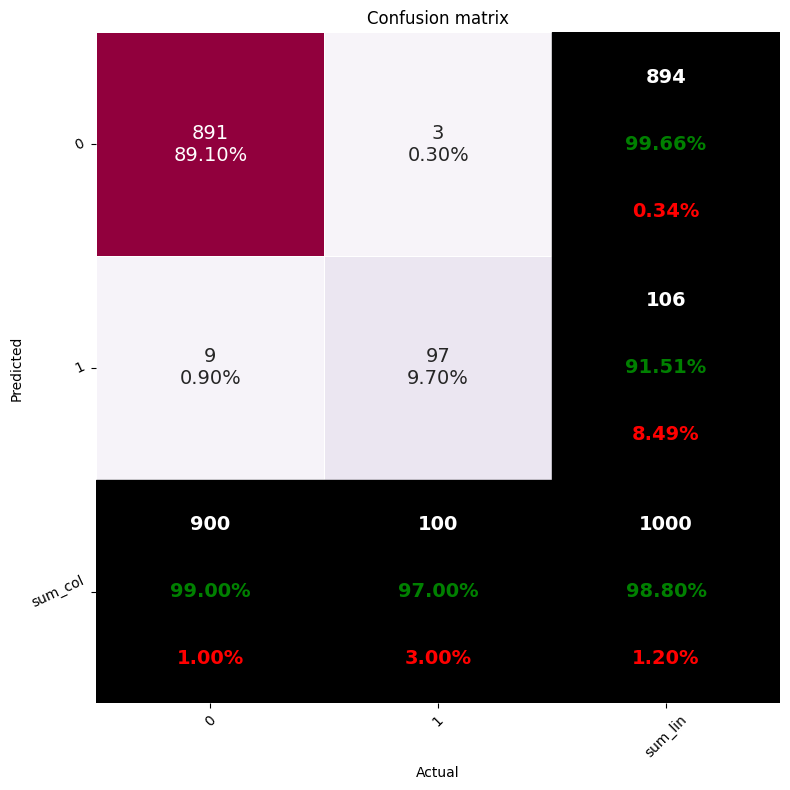

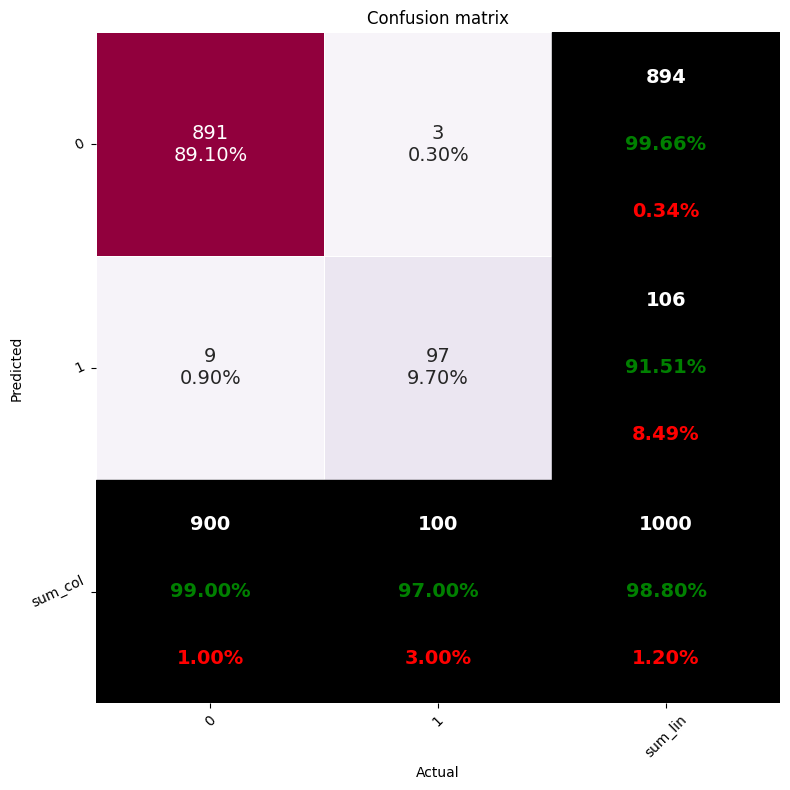

In [30]:
from sklearn.metrics import confusion_matrix
# considerando um treshould de 0.5 para good classifier
y_pred_good = df_good_classifier['score'] > 0.5
y_true_good = df_good_classifier['y_true']

cm = confusion_matrix(y_true_good, y_pred_good)
# get pandas dataframe
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0,1])
# colormap: see this and choose your more dear
cmap = "PuRd"
pp_matrix(df_cm, cmap=cmap)
